In [0]:
# Largely possible due to following notebooks and github code:
# https://colab.research.google.com/drive/101FjBAIMVuXyNyeUvq_Vfx-Z6CR3g4df#scrollTo=qvg-WGut_EpQ
# https://github.com/musikisomorphie/wgan-div/blob/master/wgan_div.py

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns
from sklearn import linear_model
from IPython.display import clear_output
import time
import os
from datetime import datetime
import json

In [2]:
# you can find all datasets at: http://fairness-measures.org/Pages/Datasets

raw_compas = pd.read_csv("https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv")
#raw_compas_2 = pd.read_csv("https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores.csv")
raw_sqf = pd.read_csv("https://www1.nyc.gov/assets/nypd/downloads/excel/analysis_and_planning/stop-question-frisk/sqf-2017.csv")
raw_schufa = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data",sep=' ',header=None)
raw_chile = pd.read_csv("https://raw.githubusercontent.com/MilkaLichtblau/BA_Simon/master/Simons_Arbeit/Chile/ADMISION2017_Refractored_replaced.csv",sep=";")

def generate_gen_out_vec(df,cat_cols):
  x = np.repeat(1,len(df.columns)-len(cat_cols))
  x = np.concatenate((x,(np.max(df[cat_cols].apply(lambda x: x.astype('category')).apply(lambda x: x.cat.codes))+1)))
  return x

def generate_heatmap(data):
    if not isinstance(data,pd.DataFrame):
      data = pd.DataFrame(data)
    corr = data.corr()
    f, ax = plt.subplots(figsize=(15, 10)) #15,10
    hm = sns.heatmap(corr, annot=True, ax=ax, cmap="coolwarm",fmt='.2f',linewidths=.05)
    f.subplots_adjust(top=0.93)
    sns.plt.show()

def simpleLM(X_train,Y_train):
  regr = linear_model.LinearRegression()
  regr.fit(X_train,Y_train)
  res = pd.DataFrame(regr.coef_,X_train.columns)  
  return res

#########################
# Compas prep:
# Used: https://github.com/propublica/compas-analysis/blob/master/Compas%20Analysis.ipynb
# as base for what is important in that dataset as they do investigation into unfairness

cmp = raw_compas[['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count', 'days_b_screening_arrest', 'decile_score', 'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out']]
cmp = cmp.query('days_b_screening_arrest <= 30 and days_b_screening_arrest >= -30 and is_recid != -1 and c_charge_degree != "O" and score_text != "N/A"')
cmp = cmp.reset_index(drop=True)


# editing such that this will work for gan
# age_cat and score_text can be derived from other variables and are therefore removed
tmp = pd.Series(delta.total_seconds()/3600 for delta in (pd.to_datetime(cmp.c_jail_out)-pd.to_datetime(cmp.c_jail_in)))
cmp['length_of_stay'] = tmp
cmp = cmp.drop(['c_jail_out','c_jail_in','age_cat','score_text'],axis=1)

# Prepare categorical columns
cat_cols = ['c_charge_degree','race','sex','is_recid','two_year_recid']

# Generate vector for number of outputs for softmax
cat_vector = generate_gen_out_vec(cmp,cat_cols)

# Create dummy variables
cmp_dum = pd.get_dummies(data=cmp, columns = cat_cols)

# Rescale numeric columns
num_cols = len(cmp.columns)-len(cat_cols)
# cmp_dum.iloc[:,:num_cols] = cmp_dum.iloc[:,:num_cols].apply(lambda x: 2*(x-x.min())/(x.max()-x.min())-1, axis=0) # 1,-1 -> be aware that you activation is currently set to sigmoid and not tanh
cmp_dum.iloc[:,:num_cols] = cmp_dum.iloc[:,:num_cols].apply(lambda x: (x-x.min())/(x.max()-x.min()), axis=0) #1,0


###############################################
###############################################
# TEST TO TRY ONLY NUMERIC VALUES:
# cmp_dum = cmp_dum.iloc[:,:2]
# cat_vector = cat_vector[:2]
###############################################
###############################################


cmp_dum_numpy = cmp_dum.copy()
cmp_dum = tf.convert_to_tensor(cmp_dum.values,dtype='float32')

X_train_onehot = cmp_dum
print(X_train_onehot.shape)


# Yoinked from colab notebook above, to create a data generator class

def generate_input_fn(is_training):
    """Creates input_fn depending on whether the code is training or not."""
    return InputFunction(is_training)

class InputFunction(object):
    """Wrapper class that is passed as callable to Estimator."""

    def __init__(self, is_training):
        self.is_training = is_training

    def __call__(self, params):
        
        data = tf.data.Dataset.from_tensor_slices(X_train_onehot)
        data = data.apply(tf.data.experimental.shuffle_and_repeat(buffer_size=X_train_onehot.shape[0]))
        
        data = data.batch(batch_size, drop_remainder=True)
        data = data.prefetch(2)
        samples = data.make_one_shot_iterator().get_next()
        #samples.set_shape([batch_size, 2])
        random_noise = tf.random_normal([batch_size, noise_dim])

        features = {
            'real': samples,
            'random_noise': random_noise}
        return features

def test_noise_input_fn(params):
    np.random.seed(0)
    noise_dataset = tf.data.Dataset.from_tensors(tf.constant(np.random.randn(params['batch_size'], noise_dim), dtype=tf.float32))
    noise = noise_dataset.make_one_shot_iterator().get_next()
    return {'random_noise': noise}, None

(6172, 19)


In [3]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import auth
auth.authenticate_user()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
MODEL_DIR = 'gs://unfairgan/model_dir'
TPU_ADDRESS = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
with tf.Session(TPU_ADDRESS) as sess:    
    with open('/content/adc.json', 'r') as f:
        auth_info = json.load(f)
    tf.contrib.cloud.configure_gcs(sess, credentials=auth_info)
print('Found TPU at: {}'.format(TPU_ADDRESS))

Found TPU at: grpc://10.33.179.98:8470


INFO:tensorflow:Using config: {'_model_dir': 'gs://unfairgan/model_dir', '_tf_random_seed': None, '_save_summary_steps': None, '_save_checkpoints_steps': 10000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
cluster_def {
  job {
    name: "worker"
    tasks {
      value: "10.33.179.98:8470"
    }
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f405ccb2898>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': b'grpc://10.33.179.98:8470', '_evaluation_master': b'grpc://10.33.179.98:8470', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_tpu_config': TPUConfig(iterations_per_loop=100, num_shards=None, num_cores_per_replica=None, p

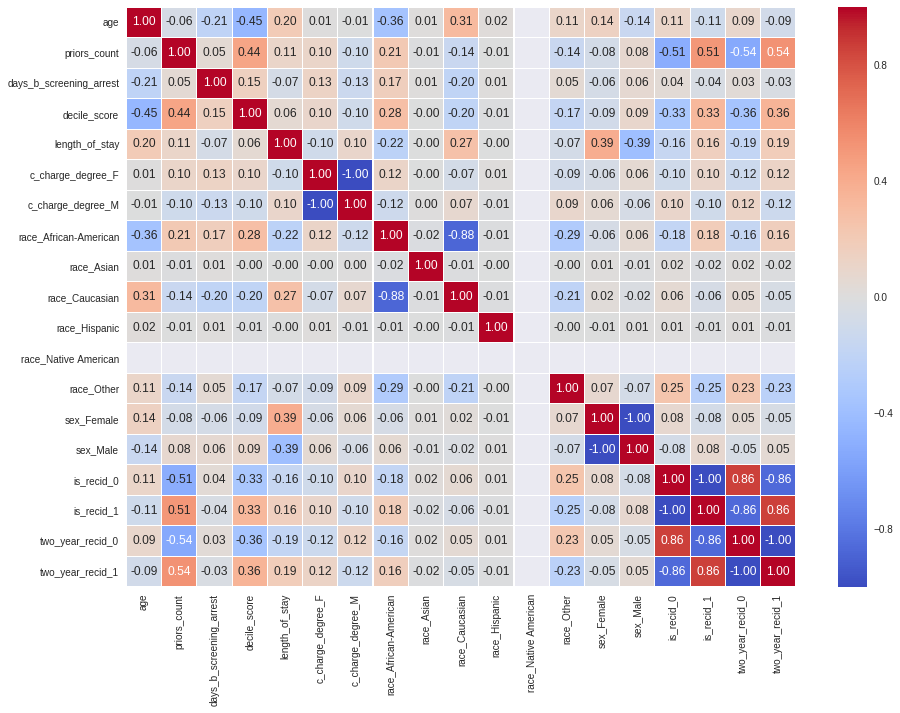

In [38]:
# Hyperparameter Definition

batch_size = 128
noise_dim = 100

iterations = 50000
learning_rate = 1e-4

#wgan div
p = 2 #previously set to 3
k = 2

# Model Definition

def LeakyReLU(x, alpha=0.2):
  return tf.maximum(alpha * x, x)

def generator(x,training=True):
  with tf.variable_scope('Generator',reuse=tf.AUTO_REUSE):
    x = tf.layers.dense(x,256,activation=LeakyReLU)
    x = tf.layers.batch_normalization(x,momentum=0.99)
    x = tf.layers.dense(x,256,activation=LeakyReLU)
    x = tf.layers.batch_normalization(x,momentum=0.99)
    x = tf.layers.dense(x,256,activation=LeakyReLU)
    x = tf.layers.batch_normalization(x,momentum=0.99)
    x = tf.layers.dense(x,256,activation=LeakyReLU)
    x = tf.layers.batch_normalization(x,momentum=0.99)
    out = []
    for i in cat_vector:
      if(i>1):
        out.append(tf.layers.dense(x,i,activation=tf.nn.softmax))
      else:
        out.append(tf.layers.dense(x,1,activation=tf.nn.sigmoid))
    x = tf.layers.flatten(tf.concat(out,1))
    return x
  
def discriminator(x,training=True):
  with tf.variable_scope('Discriminator',reuse=tf.AUTO_REUSE):
    x = tf.layers.dense(x,256,activation=LeakyReLU)
    x = tf.layers.dropout(x,0.2)
    x = tf.layers.dense(x,256,activation=LeakyReLU)
    x = tf.layers.dropout(x,0.2)
    x = tf.layers.dense(x,256,activation=LeakyReLU)
    x = tf.layers.dropout(x,0.2)
    x = tf.layers.dense(x,256,activation=LeakyReLU)
    x = tf.layers.dropout(x,0.2)
    x = tf.layers.dense(x,1)
    return x
  
def model_fn(features, mode, params):
  if mode == tf.estimator.ModeKeys.PREDICT:
    random_noise = features['random_noise']
    predictions = {'generated_samples': generator(random_noise,training=False)}
    return tf.contrib.tpu.TPUEstimatorSpec(mode=mode,predictions=predictions)

  real_data = features['real']
  random_noise = features['random_noise']
  
  print(real_data.shape)
  print(random_noise.shape)
  
  training = (mode == tf.estimator.ModeKeys.TRAIN)
  fake_data = generator(random_noise,training=training)

  disc_real = discriminator(real_data)
  disc_fake = discriminator(fake_data)

  gen_cost = tf.reduce_mean(disc_fake)
  disc_cost = tf.reduce_mean(disc_real) - tf.reduce_mean(disc_fake)
  
  epsilon = tf.random_uniform(shape=[random_noise.get_shape().as_list()[0],1],minval=0.,maxval=1.)

  differences = fake_data - real_data
  interpolates = real_data + (epsilon*differences)
  gradients = tf.gradients(discriminator(interpolates),[interpolates])[0]
  slopes = tf.pow(tf.reduce_sum(tf.square(gradients),reduction_indices=[1]),p)
  gradient_penalty = tf.reduce_mean(slopes)
  disc_cost += k*gradient_penalty

  if mode == tf.estimator.ModeKeys.TRAIN:
    gen_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0., beta2=0.9,epsilon=0.1)
    disc_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0., beta2=0.9,epsilon=0.1)

    g_tpu_opt = tf.contrib.tpu.CrossShardOptimizer(gen_train_opt)
    d_tpu_opt = tf.contrib.tpu.CrossShardOptimizer(disc_train_opt)

  # update op for batch_norm layer # i dont remember what it thought here :)

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
      d_step = d_tpu_opt.minimize(disc_cost, var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Discriminator'))
      g_step = g_tpu_opt.minimize(gen_cost, var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Generator'))

      increment_step = tf.assign_add(tf.train.get_or_create_global_step(), 1)
      joint_op = tf.group([d_step, g_step, increment_step])
      return tf.contrib.tpu.TPUEstimatorSpec(mode=mode, loss=gen_cost, train_op=joint_op)

  elif mode == tf.estimator.ModeKeys.EVAL:
    def _eval_metric_fn(disc_cost,gen_cost):
      return {'discriminator_loss': tf.metrics.mean(disc_cost),'generator_loss': tf.metrics.mean(gen_cost)}
    return tf.contrib.tpu.TPUEstimatorSpec(mode=mode, loss=tf.reduce_mean(gen_cost), eval_metrics=(_eval_metric_fn, [disc_cost, gen_cost]))
  
def sample_from_prob(samples):
  # get point where values change to find first categorical column:
  idx = np.where(cat_vector[:-1] != cat_vector[1:])[0][0]+1
  cat_vec_short = cat_vector[idx:]
  # loop over all categorical variables and sample from distributions
  for i in cat_vec_short:
    tmp = [np.random.choice(i,size=1,p=(j/np.sum(j)))[0] for j in samples.values[:,idx:i+idx]]
    dummy = np.zeros([len(tmp),i])
    dummy[np.arange(len(tmp)),tmp] = 1
    samples.values[:,idx:idx+i] = dummy
    idx += i
  return samples
 

def store_results(samples,orig):
  samples = pd.DataFrame([s['generated_samples'][:] for s in samples])
  samples.columns = orig.columns
  #create directory
  work_dir = os.path.join(os.getcwd(), 'drive/My Drive/unfairgan')
  os.makedirs(work_dir, exist_ok=True)
  #create filename
  filename = datetime.now().strftime("data-%Y-%m-%d-%H-%M.csv")
  samples.to_csv(os.path.join(work_dir,filename))
  return samples
  

tf.logging.set_verbosity(tf.logging.INFO)
config = tf.contrib.tpu.RunConfig(cluster=tf.contrib.cluster_resolver.TPUClusterResolver(TPU_ADDRESS),
                                  #save_checkpoints_secs=None,
                                  save_checkpoints_steps=10000,
                                  save_summary_steps=None,
                                  model_dir=MODEL_DIR,
                                  tpu_config=tf.contrib.tpu.TPUConfig(iterations_per_loop=100)
                                 )

# I yoinked this part from the first colab notebook in above citations, i'm assuming
# we use the cpu to predict so that we are actually on this machine to predict

# TPU-based estimator used for TRAIN and EVAL
est = tf.contrib.tpu.TPUEstimator(
        model_fn=model_fn,
        config=config,
        train_batch_size=batch_size,
        eval_batch_size=batch_size)

# CPU-based estimator used for PREDICT (generating images)
cpu_est = tf.contrib.tpu.TPUEstimator(
        model_fn=model_fn,
        use_tpu=False,
        config=config,
        predict_batch_size=7000)

current_step = 0

steps_per_eval = 1000

start_time = time.time()

est.train(input_fn=generate_input_fn(True),max_steps=iterations)
#plot_test_result(cpu_est.predict(input_fn=test_noise_input_fn))
pred_res = store_results(cpu_est.predict(input_fn=test_noise_input_fn),cmp_dum_numpy)
print("Total runtime: %d seconds" %(time.time()-start_time))
pred_res_sampled = sample_from_prob(pred_res)
generate_heatmap(pred_res_sampled)

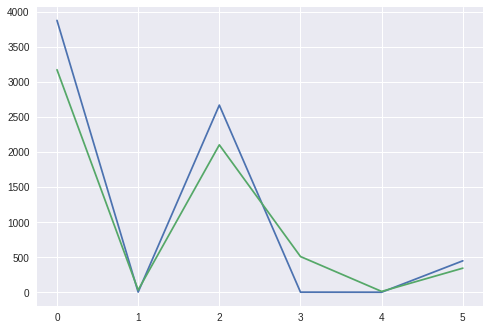

In [39]:
plt.plot(np.sum(pred_res_sampled.values[:,7:13],axis=0))
plt.plot(np.sum(cmp_dum_numpy.values[:,7:13],axis=0))

In [37]:
# clear bucket
!gsutil -m rm gs://unfairgan/model_dir/**

Removing gs://unfairgan/model_dir/...
Removing gs://unfairgan/model_dir/checkpoint...
Removing gs://unfairgan/model_dir/events.out.tfevents.1548059085.0bba77b576fa...
Removing gs://unfairgan/model_dir/model.ckpt-10000.meta...
Removing gs://unfairgan/model_dir/model.ckpt-10000.index...
Removing gs://unfairgan/model_dir/graph.pbtxt...
Removing gs://unfairgan/model_dir/model.ckpt-10000.data-00000-of-00001...
Removing gs://unfairgan/model_dir/model.ckpt-20000.data-00000-of-00001...
Removing gs://unfairgan/model_dir/model.ckpt-20000.index...
Removing gs://unfairgan/model_dir/model.ckpt-20000.meta...
Removing gs://unfairgan/model_dir/model.ckpt-30000.data-00000-of-00001...
Removing gs://unfairgan/model_dir/model.ckpt-40000.data-00000-of-00001...
Removing gs://unfairgan/model_dir/model.ckpt-30000.index...
Removing gs://unfairgan/model_dir/model.ckpt-30000.meta...
Removing gs://unfairgan/model_dir/model.ckpt-40000.index...
Removing gs://unfairgan/model_dir/model.ckpt-40000.meta...
Removing gs: